In [1]:
from qiskit.quantum_info import Operator, Pauli, PTM, pauli_basis
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import depolarizing_error, NoiseModel, pauli_error

import numpy as np
from random import choices, random
from numpy.random import permutation
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit

In [2]:
n=2
names = ["".join(str) for str in product(['I', 'X', 'Y','Z'], repeat=n)]
paulis = [Operator(Pauli(name)) for name in names]

def get_name(pauli_op):
    try:
        return names[min([i for (i,gate) in enumerate(paulis) if pauli_op.equiv(gate)])]
    except:
        return -1

def conjugate(pauli, cliffordop):
    return get_name(cliffordop.compose(Operator(Pauli(pauli).to_matrix())).compose(cliffordop))

In [3]:
p_group = pauli_basis(n, pauli_list = True).to_labels()
p_group_permuted = [conjugate(p, Operator(CXGate())) for p in p_group]
pairs = list(zip(p_group, p_group_permuted))
print(pairs)

[('II', 'II'), ('IX', 'XX'), ('IY', 'XY'), ('IZ', 'IZ'), ('XI', 'XI'), ('XX', 'IX'), ('XY', 'IY'), ('XZ', 'XZ'), ('YI', 'YZ'), ('YX', 'ZY'), ('YY', 'ZX'), ('YZ', 'YI'), ('ZI', 'ZZ'), ('ZX', 'YY'), ('ZY', 'YX'), ('ZZ', 'ZI')]


II : (1+0j)
IX : (0.9239317140268455+0j)
IY : (0.9713601301833792+0j)
IZ : (0.9525715838434664+0j)
XI : (0.9486811660744982+0j)
XX : (0.9258356284650608+0j)
XY : (0.9732640446215945+0j)
XZ : (0.9012527499179644+0j)
YI : (0.9525715838434664+0j)
YX : (0.9713601301833792+0j)
YY : (0.9239317140268455+0j)
YZ : (1+0j)
ZI : (0.9012527499179644+0j)
ZX : (0.9732640446215945+0j)
ZY : (0.9258356284650608+0j)
ZZ : (0.9486811660744982+0j)


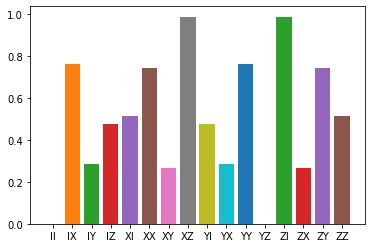

In [51]:
errorgen = 4
errorops = choices(p_group, k=errorgen)
errorprobs = [random()*.1/errorgen for op in errorops]
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

real_errors = {}
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data
for i,pauli in enumerate(pauli_basis(2, pauli_list = True)):
    real_errors[pauli.to_label()] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real)
    print(pauli, ":", transfer_matrix[i][i])

SHOTS = 50000

In [5]:
def get_expectation(circuit, pauli_str, noise = True):
    circ = circuit.copy()
    circ.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    if noise:
        counts = execute(circ, backend, shots = SHOTS, noise_model = noise_model, basis_gates = noise_model.basis_gates, optimization_level=0).result().get_counts()
    else:
        counts = execute(circ, backend, shots = SHOTS).result().get_counts()
    total = 0
    for key in counts.keys():
        pauli_weight = [{"I":'0'}.get(p,'1') for p in pauli_str]
        total += (-1)**sum([{('1','1'):1}.get((pauli_bit, key_bit), 0) for pauli_bit, key_bit in zip(pauli_weight, key)])*counts[key]
    return total/SHOTS

def measure_circuit(pauli_prep, pauli_meas, depth):
    total = 0
    qc = QuantumCircuit(2)
    for i,p in enumerate(pauli_prep[::-1]):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.h(i)
                qc.s(i)
    for i in range(depth):
        qc.cx(0,1)
    for i,p in enumerate(pauli_meas[::-1]):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.sdg(i)
                qc.h(i)
    return qc 

In [6]:
single_pairs = set()
for p1, p2 in zip(p_group, p_group_permuted):
    if 'I' in p1 and not 'I' in p2:
        single_pairs.add((p2,p1))
    if 'I' in p2 and not 'I' in p1:
        single_pairs.add((p1,p2))
print(single_pairs)

{('YZ', 'YI'), ('ZZ', 'ZI'), ('XY', 'IY'), ('XX', 'IX')}


In [7]:
for double, single in single_pairs:
    circ = measure_circuit(double,double,1)
    print(single, get_expectation(circ, single), real_errors[single]) #no spam, otherwise divide by single measurement

YI 0.9716 (0.9729524585516107+0j)
ZI 0.9616 (0.9647729619793406+0j)
IY 0.9966 (0.9972145115650285+0j)
IX 0.976 (0.9717332673461886+0j)


In [8]:
circ.draw()

┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ H ├
     ├───┤┌─┴─┐├───┤
q_1: ┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘

In [9]:
depths = [1,3,5,7,9,11,13]
for double, single in single_pairs:
    res = []
    for d in depths:
        circ = measure_circuit(double, double, d)
        res.append(get_expectation(circ, single))
    expfit = lambda x,a,b: np.exp(-b*x)*a
    popt, pcov = curve_fit(expfit, depths, res)
    fid = expfit(1,1,popt[1])
    print(single, "real:", real_errors[single], "measured:", fid, "pair:", np.sqrt(real_errors[single]*real_errors[double]))

YI real: (0.9729524585516107+0j) measured: 0.985621344029883 pair: (0.9856107374675349+0j)
ZI real: (0.9647729619793406+0j) measured: 0.951721255901727 pair: (0.9519470850349094+0j)
IY real: (0.9972145115650285+0j) measured: 0.968638682716576 pair: (0.9684477924524552+0j)
IX real: (0.9717332673461886+0j) measured: 0.9697911731820542 pair: (0.9688584577971178+0j)


In [10]:
depths = [2,4,6,8,10,12,14]
for double, single in single_pairs:
    res = []
    for d in depths:
        circ = measure_circuit(double, double, d)
        res.append(get_expectation(circ, double))
    expfit = lambda x,a,b: np.exp(-b*x)*a
    popt, pcov = curve_fit(expfit, depths, res)
    fid = expfit(1,1,popt[1])
    print(double, "real:", real_errors[double], "measured:", fid, "pair:", np.sqrt(real_errors[single]*real_errors[double]))

YZ real: (0.9984337027704506+0j) measured: 0.9868341440771335 pair: (0.9856107374675349+0j)
ZZ real: (0.9392917177605007+0j) measured: 0.9509938989005451 pair: (0.9519470850349094+0j)
XY real: (0.9405109089659228+0j) measured: 0.9680589060239169 pair: (0.9684477924524552+0j)
XX real: (0.9659921531847627+0j) measured: 0.9694521909248448 pair: (0.9688584577971178+0j)


In [11]:
for p1, p2 in pairs:
    circ = measure_circuit(p1, p2, 1)
    res = get_expectation(circ, p2)
    print(p2, "measured:", np.abs(res), "ideal", real_errors[p2])

II measured: 1.0 ideal (1+0j)
XX measured: 0.9658 ideal (0.9659921531847627+0j)
XY measured: 0.9442 ideal (0.9405109089659228+0j)
IZ measured: 0.9772 ideal (0.9745187557811601+0j)
XI measured: 0.9452 ideal (0.9377254205309513+0j)
IX measured: 0.9738 ideal (0.9717332673461886+0j)
IY measured: 0.9968 ideal (0.9972145115650285+0j)
XZ measured: 0.9666 ideal (0.9632066647497912+0j)
YZ measured: 0.9988 ideal (0.9984337027704506+0j)
ZY measured: 0.9634 ideal (0.9644258559552134+0j)
ZX measured: 0.9412 ideal (0.9389446117363734+0j)
YI measured: 0.9758 ideal (0.9729524585516107+0j)
ZZ measured: 0.9394 ideal (0.9392917177605007+0j)
YY measured: 0.9764 ideal (0.973299564575738+0j)
YX measured: 0.9988 ideal (0.9987808087945779+0j)
ZI measured: 0.96 ideal (0.9647729619793406+0j)


In [12]:
double_pairs = []
for p1, p2 in pairs:
    if not ("I" in p1 or "I" in p2 or (p2,p1) in double_pairs or p1 == p2):
        double_pairs.append((p1,p2))

print(double_pairs)

[('YX', 'ZY'), ('YY', 'ZX')]


In [44]:
def measure_double(pauli, pauli_pair, depth):
    qc = QuantumCircuit(n)

    for i,p in enumerate(pauli[::-1]):
        match p:
            case "X":
                qc.h(i)
            case "Y":
                qc.h(i)
                qc.s(i)

    qc.barrier()
    
    for j in range(depth):
        for i,p in enumerate(zip(pauli[::-1], pauli_pair[::-1])):
            match p:
                case ("X","Y"):
                    qc.s(i)
                case ("X", "Z"):
                    qc.h(i)
                case ("Y", "X"):
                    qc.sdg(i)
                case ("Y", "Z"):
                    qc.sdg(i)
                    qc.h(i)
                case ("Z", "X"):
                    qc.h(i)
                case ("Z", "Y"):
                    qc.h(i)
                    qc.s(i)
        qc.cx(0,1) 

        qc.barrier()
        
    for i,p in enumerate(pauli[::-1]):
        match p:
            case "X":
                qc.h(i)
            case "Y":
                qc.sdg(i)
                qc.h(i)

    return qc

In [45]:
def measure_single(single, double):
    circ = measure_double(single, single, 0)
    result0 = get_expectation(circ, single)
    circ = measure_double(double, single, 1)
    result1 = get_expectation(circ, single)
    
    return result1/result0

# Full Procedure

In [46]:
easy_set = set(p1 for (p1, p2) in pairs if p1==p2)
medium_set = set([(p1,p2) for (p1,p2) in pairs if not ("I" in p1 or "I" in p2) and p1 != p2])
hard_set = set([(p1, p2) for (p1, p2) in pairs if (not "I" in p1 and "I" in p2) and not p2 in easy_set])

In [52]:
measured_errors = {}
depths = [2,4,6,8,10,12] #has to be even

for p in easy_set:
    results = []
    for d in depths:
        circ = measure_double(p, p, d)
        results.append(get_expectation(circ, p))
    popt, pcov = curve_fit(expfit, depths, results)
    measured_errors[p] = np.exp(-popt[1])

/home/ben/.local/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [53]:
for p1, p2 in medium_set.union(hard_set):
    results = []
    for d in depths:
        circ = measure_double(p1, p2, d)
        results.append(get_expectation(circ, p1))
    popt, pcov = curve_fit(expfit, depths, results) 
    measured_errors[p1] = np.exp(-popt[1])

In [54]:
for double, single in hard_set:
    single_err = measure_single(single, double)
    measured_errors[single] = single_err
    measured_errors[double] = measured_errors[double]**2/single_err

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


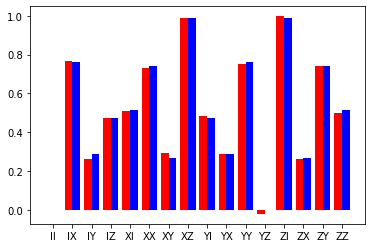

In [55]:
labels = []
real_bar = []
measured_bar = []
for pauli in pauli_basis(2, pauli_list = True).to_labels():
    labels.append(pauli)
    real_bar.append(10*(1-real_errors[pauli]))
    measured_bar.append(10*(1-measured_errors[pauli]))

ax = np.arange(len(labels))
plt.bar(ax+.2, real_bar, .4, color='b')
plt.bar(ax-.2, measured_bar, .4, color='r')
plt.xticks(ax, labels);

In [56]:
from qiskit.providers.fake_provider import FakeQuito
from qiskit.quantum_info import SuperOp

In [53]:
backend = FakeQuito()
quito_noisemodel = NoiseModel.from_backend(backend)

In [54]:
channel = quito_noisemodel._local_quantum_errors['cx'][(1,2)].to_quantumchannel().data
twirled_channel = np.zeros([16,16])
for p in pauli_basis(2, pauli_list = True):
    mat = p.to_matrix()
    op = np.kron(np.conjugate(mat), mat)
    twirled_channel = np.add(twirled_channel, op @ channel @ op)
trans = PTM(SuperOp(twirled_channel/16)).data
cx_errors = {}
for i,p in enumerate(pauli_basis(2, pauli_list = True).to_labels()):
    cx_errors[p] = trans[i][i]